### Freezing some layers

In [21]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

np.random.seed(1)
tf.set_random_seed(1)

# DQN+MLP with one hidden layer
class MLP1():
    def __init__(self,
                n_actions, 
                n_features,
                learning_rate=0.01,
                reward_decay=0.9,
                e_greedy=0.9,
                replace_target_iter=300,
                memory_size=500
                ):
        self.n_actions= n_actions
        self.n_features= n_features
        self.lr= learning_rate
        self.gamma= reward_decay
        self.epsilon_max= e_greedy
        self.replace_target_iter= replace_target_iter
        self.memory_size= memory_size
        self.epsilon= e_greedy
        
        # Total learning step
        self.learn_step_counter= 0
        
        # Initialize zero-memory [s, a, r, s_]
        self.memory= np.zeros((self.memory_size, n_features*2+2))
        
        # Consist of [target_net, evaluate_net]
        self.nInternalUnits=64
        self._build_net(self.nInternalUnits)
        
        self.sess= tf.Session()
        
        #with tf.compat.v1.Session() as sess:
            
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.replace_target_op)
        
        self.cost_his=[]
        
        
    def _build_net(self, nInternalUnits):
        # Build evaluate net
        #tf.compat.v1.disable_eager_execution()
        self.s= tf.placeholder(tf.float32, [None, self.n_features])# Input
        self.q_target= tf.placeholder(tf.float32, [None, self.n_actions])# for calculating loss
        
        
        self.w1_eval= tf.Variable(tf.random.normal([self.n_features, nInternalUnits], mean=0.0, stddev=0.3)) 
        self.b1_eval= tf.Variable(tf.random.normal([1, nInternalUnits], mean=0, stddev=0.3))
        self.l1_eval= tf.nn.tanh(tf.matmul(self.s, self.w1_eval)+self.b1_eval)
        
        self.w2_eval= tf.Variable(tf.random.normal([nInternalUnits, nInternalUnits], mean=0.0, stddev=0.3))
        self.b2_eval= tf.Variable(tf.random.normal([1, nInternalUnits], mean=0.0, stddev=0.3))
        self.l2_eval=tf.matmul(self.l1_eval, self.w2_eval)+self.b2_eval
        
        self.w3_eval = tf.Variable(tf.random_normal([nInternalUnits, nInternalUnits], mean=0.0, stddev=0.3), trainable= False)
        self.b3_eval = tf.Variable(tf.random_normal([1, nInternalUnits], mean=0.0, stddev=0.3), trainable= False)
        self.l3_eval = tf.matmul(self.l2_eval, self.w3_eval) + self.b3_eval
        
        self.w4_eval = tf.Variable(tf.random_normal([nInternalUnits, self.n_actions], mean=0.0, stddev=0.3), trainable= False)
        self.b4_eval = tf.Variable(tf.random_normal([1, self.n_actions], mean=0.0, stddev=0.3), trainable= False)
        self.q_eval = tf.matmul(self.l3_eval, self.w4_eval) + self.b4_eval
        
        
        
        
        self.loss= tf.reduce_mean(tf.math.squared_difference(self.q_target, self.q_eval))
        self._train_op= tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        
        # Build target net
        self.s_= tf.compat.v1.placeholder(tf.float32, [None, self.n_features])# Input
        
        self.w1_target= tf.Variable(tf.random.normal([self.n_features, nInternalUnits], mean=0.0, stddev=0.3))
        self.b1_target= tf.Variable(tf.random.normal([1, nInternalUnits], mean=0, stddev=0.3))
        self.l1_target= tf.nn.tanh(tf.matmul(self.s_, self.w1_target)+self.b1_target)
        
        self.w2_target= tf.Variable(tf.random.normal([nInternalUnits, nInternalUnits], mean=0.0, stddev=0.3))
        self.b2_target= tf.Variable(tf.random.normal([1, nInternalUnits], mean=0.0, stddev=0.3))
        self.l2_target= tf.matmul(self.l1_target, self.w2_target)+self.b2_target
        
        self.w3_target = tf.Variable(tf.random_normal([nInternalUnits, nInternalUnits], mean=0.0, stddev=0.3), trainable= False)
        self.b3_target = tf.Variable(tf.random_normal([1, nInternalUnits], mean=0.0, stddev=0.3), trainable= False)
        self.l3_target = tf.matmul(self.l2_target, self.w3_target)+self.b3_target
        
        self.w4_target = tf.Variable(tf.random_normal([nInternalUnits, self.n_actions], mean=0.0, stddev=0.3), trainable= False)
        self.b4_target = tf.Variable(tf.random_normal([1, self.n_actions], mean=0.0, stddev=0.3), trainable= False)
        self.q_next = tf.matmul(self.l3_target, self.w4_target) + self.b4_target
        
        
        
        
        
        self.replace_target_op= [tf.compat.v1.assign(self.w1_target, self.w1_eval), tf.compat.v1.assign(self.b1_target, self.b1_eval),
                                tf.compat.v1.assign(self.w2_target, self.w2_eval), tf.compat.v1.assign(self.b2_target, self.b2_eval)
                                
                                ]
        
        
    def store_transition(self, s, a, r, s_):
        
        if not hasattr (self, 'memory_counter'):
            self.memory_counter=0
        
        
        transition= np.hstack((s, [a, r], s_))
        
        #Replace the old memory with new memory
        index= self.memory_counter % self.memory_size
        self.memory[index, :]= transition
        
        self.memory_counter+=1
        
    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation= observation[np.newaxis, :]
        
        if np.random.uniform()<self.epsilon:
            action= np.random.randint(0, self.n_actions)
        else:
            # Forward feed the observation and get the q_value for every actions
            actions_value= self.sess.run(self.q_eval, feed_dict= {self.s: observation})
            action= np.argmax(actions_value)
            
        return action
    
    def learn(self):
        
        batch_memory= self.memory
        with tf.compat.v1.Session() as sess:
            
            q_next, q_eval= self.sess.run(
                [self.q_next, self.q_eval],
                feed_dict= {
                    self.s_: batch_memory[:,-self.n_features:],# fixed params
                    self.s: batch_memory[:, :self.n_features], #newest params
                })
        # Change the q_target with q_eval's actions
        q_target= q_eval.copy()
        
        eval_act_index= batch_memory[:, self.n_features].astype(int)
        reward= batch_memory[:, self.n_features+1]
        
        next_q_value= self.gamma*np.max(q_next, axis=1)
        
        
        for index in range(len(eval_act_index)):
            q_target[index, eval_act_index[index]]= reward[index]+next_q_value[index]
            
            
        # Train eval network
        with tf.compat.v1.Session() as sess:
            
            _, self.cost= self.sess.run([self._train_op, self.loss], 
                                       feed_dict= {self.s: batch_memory[:, :self.n_features], self.q_target:q_target})
        
        self.cost_his.append(self.cost)
        
        # Replace target parameters
        if self.learn_step_counter % self.replace_target_iter==0:
            self.sess.run(self.replace_target_op)
        
        self.learn_step_counter+=1

In [22]:
class DSA_Markov():
    def __init__(self,
                n_channel,
                n_su,
                sense_error_prob_max=0.2,
                punish_interfer_PU=-2):
        self.n_channel= n_channel # The number of channels
        self.n_su= n_su # then number of secondary users
        
        # Initialize the Markov channels
        self._build_Markov_channel()
        
        # Initialize the locations of SUs and PUs
        self._build_location()
        
        # Set the noise(Mw)
        self.Noise= 1*np.float_power(10,-8)
        # Set the carrier frequency (5 Ghz)
        self.fc= 5
        # Set the k in channel gain
        self.k= 8
        # Set the power of PU and SU(mw)
        self.SU_power= 20
        self.PU_power= 40
        
        # Initialize SINR(no consideration of interference of SUs)
        self.render_SINR()
        
        self.n_actions= n_channel+1 # The action space size
        self.n_features= n_channel # The sensing result space
        
        self.sense_error_prob_max= sense_error_prob_max
        self.sense_error_prob= np.random.uniform(0, self.sense_error_prob_max, size=(self.n_su, self.n_channel))
        
        # The punishment for interferring PUs
        self.punish_interfer_PU= punish_interfer_PU
        
    def _build_Markov_channel(self):
        # Initialize channel state(uniform distribution)
        # 1: Inactive Pu
        # 0: Active Pu
        
        self.channel_state= np.random.choice(2, self.n_channel)
        
        # Initialize the transition probability of independent channels
        self.stayGood_prob= np.random.uniform(0.7, 1, self.n_channel)
        self.stayBad_prob= np.random.uniform(0, 0.3, self.n_channel)
        self.goodToBad_prob= 1- self.stayGood_prob
        self.badToGood_prob= 1- self.stayBad_prob
        
    def _build_location(self):
        # Initialize the location of PUs
        self.PU_TX_x= np.random.uniform(0, 150, self.n_channel)
        self.PU_TX_y= np.random.uniform(0, 150, self.n_channel)
        self.PU_RX_x= np.random.uniform(0, 150, self.n_channel)
        self.PU_RX_y= np.random.uniform(0, 150, self.n_channel)
        
        
        # Initialize the location of SUs transmitters
        self.SU_TX_x= np.random.uniform(0+40, 150-40, self.n_su)
        self.SU_TX_y= np.random.uniform(0+40, 150-40, self.n_su)
        
        # Initialize the distance between SU's transmitter and receiver
        self.SU_d= np.random.uniform(20, 40, self.n_su)
        
        # Initialize the location of SUs receivers
        SU_theda= 2*np.pi*np.random.uniform(0, 1, self.n_su)
        SU_dx= self.SU_d*np.cos(SU_theda)
        SU_dy= self.SU_d*np.sin(SU_theda)
        self.SU_RX_x= self.SU_TX_x+ SU_dx
        self.SU_RX_y= self.SU_TX_y+ SU_dy
        
        # Compute the distance between PU_Tx and SU_Rx
        self.SU_RX_PU_TX_d= np.zeros((self.n_su, self.n_channel))
        for k in range(self.n_su):
            for l in range(self.n_channel):
                self.SU_RX_PU_TX_d[k][l]= np.sqrt(
                np.float_power((self.SU_RX_x[k]-self.PU_TX_x[l]),2)+
                    np.float_power((self.SU_RX_y[k]-self.PU_TX_y[l]), 2)
                )
        
        # Compute the distance between SU_TX and SU_RX
        self.SU_RX_SU_TX_d= np.zeros((self.n_su, self.n_su))
        for k1 in range(self.n_su):
            for k2 in range(self.n_su):
                self.SU_RX_SU_TX_d[k1][k2]= np.sqrt(
                np.float_power(self.SU_RX_x[k1]-self.SU_TX_x[k2], 2)+
                    np.float_power(self.SU_RX_y[k1]-self.SU_TX_y[k2], 2)
                )
        # Plot the locations
        plt.plot(self.PU_TX_x, self.PU_TX_y,'ro',label='PU_TX' )
        plt.plot(self.PU_RX_x, self.PU_RX_y,'rx' ,label='PU_RX')
        plt.plot(self.SU_TX_x, self.SU_TX_y,'bs',label='SU_TX')
        plt.plot(self.SU_RX_x, self.SU_RX_y,'b^',label='SU_RX')
        plt.legend(loc='lower right')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()
        
        
    def store_action(self, action):
        self.action= action
        
    def sense(self):
        tmp_dice= np.random.uniform(0, 1, size=(self.n_su, self.n_channel))
        error_index= tmp_dice< self.sense_error_prob # True: sensing error happens, False: sensing is correct
        
        # Get the sensing result
        self.sensing_result= self.channel_state*(1-error_index)+ (1-self.channel_state)*error_index
        return self.sensing_result

    def access(self, action):
        # action[0 - n_channel-1]: 
        # action n_channel:
        self.success=0
        self.fail_PU=0
        self.fail_collision=0
        
        self.reward= np.zeros(self.n_su)
        
            # To check the number of same actions
        def eqlen(a, b):
            i=0
            for j in range(len(a)):
                if a[j]==b:
                    i=i+1
            return i
        #Calculate the interference of SUs
        Interference_SU=0
        SU_sigma2= np.float_power(10, -((41+22.7*np.log10(self.SU_RX_SU_TX_d)+20*np.log10(self.fc/5))/10))
        
        for k in range(self.n_su):
            SU_sigma2[k][k]=0
            
        for k in range(self.n_su):
            if (action[k]==self.n_channel): # Not choosing any channel
                self.reward[k]=0
            else: 
                for q in range(self.n_su):
                    if (action[q]==action[k]):
                        Interference_SU= Interference_SU+ SU_sigma2[k][q]*self.SU_power
                SINR= self.H2[k, action[k]]*self.SU_power/(Interference_SU+self.Interference_PU[k, action[k]]+self.Noise)
                self.reward[k]= np.log2(1+SINR)
                
                if (self.channel_state[action[k]]==1):
                    if (len(np.where(action==action[k])[0])==1):
                    
                    #if eqlen(action, action[k])==1:
                        #Successful transmission
                        self.success=self.success+1
                    else:
                        #Collision with SU
                        self.fail_collision=self.fail_collision+1
                        
                else:
                    #collision with PU
                    self.fail_PU=self.fail_PU+1
                    self.reward[k]= self.punish_interfer_PU
                    if (len(np.where(action==action[k])[0])> 1):
                    #if eqlen(action, action[k])>1:
                        #Collision with Su
                        self.fail_collision=self.fail_collision+1
        return self.reward
                
                
    def render(self):
        # The probability of staying in current state in next time-slot
        stay_prob= self.channel_state*self.stayGood_prob + (1-self.channel_state)*self.stayBad_prob
        tmp_dice= np.random.uniform(0, 1, self.n_channel)
        stay_index= tmp_dice<stay_prob
        self.channel_state= self.channel_state*stay_index+(1-self.channel_state)*(1-stay_index)
        
        
        
    def render_SINR(self):
        # Update the SINR
        
        # Calculate the channel gain
        SU_d= copy.deepcopy(np.reshape(self.SU_d, (-1, 1)))
        for n in range(self.n_channel-1):
            SU_d= np.hstack((SU_d, np.reshape(self.SU_d, (-1, 1))))
            
        SU_sigma2= np.float_power(10, -((41+22.7*np.log10(SU_d)+ 20*np.log10(self.fc/5))/10))
        CN_real= np.random.normal(0, 1, size=(self.n_su, self.n_channel))
        CN_imag= np.random.normal(0, 1, size=(self.n_su, self.n_channel))
        theda= np.random.uniform(0, 1, size=(self.n_su, self.n_channel))
        H= np.sqrt(self.k/(self.k+1)*SU_sigma2)*np.exp(1j*2*np.pi*theda)+np.sqrt(1/(self.k+1)*SU_sigma2/2)*(CN_real+1j*CN_imag)
        self.H2= np.float_power(np.absolute(H), 2)
        
        # Calculate the interference of PUs
        PU_sigma2= np.float_power(10, -((41+22.7*np.log10(self.SU_RX_PU_TX_d)+ 20*np.log10(self.fc/5))/10))
        channel_state= np.array([self.channel_state for k in range(self.n_su) ])
        self.Interference_PU= self.PU_power*PU_sigma2*(1-channel_state)
        
        self.SINR= self.H2*self.SU_power/(self.Interference_PU+self.Noise)

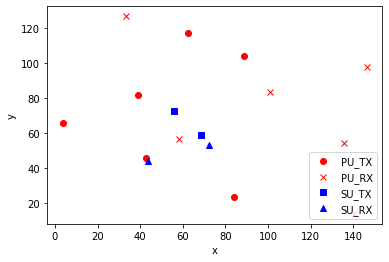

Training time=2000;  success=1315;  fail_PU=290;  fail_collision=243
Overall reward 3.8398
Training time=4000;  success=1272;  fail_PU=264;  fail_collision=256
Overall reward 3.7408
Training time=6000;  success=1269;  fail_PU=279;  fail_collision=251
Overall reward 3.7250
Training time=8000;  success=1341;  fail_PU=258;  fail_collision=248
Overall reward 3.9818
Training time=10000;  success=1279;  fail_PU=287;  fail_collision=282
Overall reward 3.7368
Training time=12000;  success=1311;  fail_PU=285;  fail_collision=242
Overall reward 3.8394
Training time=14000;  success=1336;  fail_PU=268;  fail_collision=241
Overall reward 3.9597
Training time=16000;  success=1367;  fail_PU=243;  fail_collision=233
Overall reward 4.0553
Training time=18000;  success=1328;  fail_PU=215;  fail_collision=256
Overall reward 3.9666
Training time=20000;  success=1342;  fail_PU=239;  fail_collision=243
Overall reward 3.9867
Training time=22000;  success=1285;  fail_PU=276;  fail_collision=245
Overall reward

Training time=182000;  success=1926;  fail_PU=74;  fail_collision=0
Overall reward 5.9687
Training time=184000;  success=1939;  fail_PU=60;  fail_collision=0
Overall reward 6.0256
Training time=186000;  success=1935;  fail_PU=65;  fail_collision=0
Overall reward 6.0225
Training time=188000;  success=1934;  fail_PU=65;  fail_collision=0
Overall reward 6.0138
Training time=190000;  success=1934;  fail_PU=65;  fail_collision=0
Overall reward 6.0187
Training time=192000;  success=1934;  fail_PU=65;  fail_collision=0
Overall reward 6.0088
Training time=194000;  success=1938;  fail_PU=62;  fail_collision=0
Overall reward 6.0160
Training time=196000;  success=1936;  fail_PU=63;  fail_collision=0
Overall reward 6.0005
Training time=198000;  success=1932;  fail_PU=68;  fail_collision=0
Overall reward 5.9994
Epsilon updated to 0.0
Training time=200000;  success=1932;  fail_PU=67;  fail_collision=0
Overall reward 5.9918
Training time=202000;  success=1941;  fail_PU=59;  fail_collision=0
Overall r

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import copy
if __name__=="__main__":
    random_seed= 3
    np.random.seed(random_seed)
    
    # Initialize the environment
    n_channel=6
    n_su=2
    env=DSA_Markov(n_channel, n_su)
    env_copy= copy.deepcopy(env)
    
    # Training parameters
    if n_channel==6:
        batch_size=2000
        
    elif n_channel==15:
        batch_size=2000
        
    elif n_channel==22:
        batch_size=3000
    
    replace_target_iter=1
    total_episode= batch_size*replace_target_iter*140
    epsilon_update_period= batch_size*replace_target_iter*20
    e_greedy= [0.7, 0.5, 0]
    learning_rate=0.01
    
    
    flag_DQN_RC= True
    flag_Myopic= True
    flag_DQN_MLP1= True
    
    '''Compare with DQN_MLP1'''
    if flag_DQN_MLP1:
        env=copy.deepcopy(env_copy)
        # Initialize the DQN_MLP1(One hidden layer)
        DQN_MLP1_list=[]
        epsilon_index=np.zeros(n_su, dtype=int)
        for k in range(n_su):
            DQN_tmp=MLP1(env.n_actions, env.n_features, 
                        learning_rate=learning_rate,
                        reward_decay=0.9,
                        e_greedy=e_greedy[0],
                        replace_target_iter=replace_target_iter,
                        memory_size=batch_size)
            DQN_MLP1_list.append(DQN_tmp)
            
        #SUs sense the environment and get the sensing result(contains sensing errors)
        observation=env.sense()
        #observation= observation.reshape(-1, 1, n_channel)
        # Initialize some record vlaues
        reward_sum=np.zeros(n_su)
        reward_hist=[]
        overall_reward_4=[]
        success_hist_4=[]
        fail_PU_hist_4=[]
        fail_collision_hist_4=[]
        success_sum=0
        fail_PU_sum=0
        fail_collision_sum=0
        
        
        action=np.zeros(n_su).astype(np.int32)
        for step in range(total_episode):
            # SU choose action based on observation
            for k in range(n_su):
                action[k]=DQN_MLP1_list[k].choose_action(observation[k, :])
            # Update the environment based on independent Markov Chains
            env.render()
            env.render_SINR()
            # SU take action and obtain reward
            reward= env.access(action)
            # Record the reward, number of success, interference and collision
            reward_sum=reward_sum+reward
            success_sum=success_sum+env.success
            fail_PU_sum= fail_PU_sum+env.fail_PU
            fail_collision_sum=fail_collision_sum+env.fail_collision
            
            # SU sense the environment and get the sensing result
            observation_= env.sense()
            #observation= observation_.reshape(-1, 1, n_channel)
            
            # Store one episode(s, a, r, s_)
            for k in range(n_su):
                state= observation[k, :].reshape(-1)
                state_= observation_[k, :].reshape(-1)
                DQN_MLP1_list[k].store_transition(state, action[k], reward[k], state_)
                
            #Each SU learns their model
            if ((step+1)%batch_size==0):
                for k in range(n_su):
                    DQN_MLP1_list[k].learn()
                # Record reward, number of success/interference/collision
                overall_reward_4.append(np.sum(reward_sum)/batch_size/n_su)
                success_hist_4.append(success_sum/n_su)
                fail_PU_hist_4.append(fail_PU_sum/n_su)
                fail_collision_hist_4.append(fail_collision_sum/n_su)

                # After one batch, refresh the record
                reward_sum=np.zeros(n_su)
                success_sum=0
                fail_PU_sum=0
                fail_collision_sum=0
            
            
            # Update epsilon
            if ((step+1)%epsilon_update_period==0):
                for k in range(n_su):
                    epsilon_index[k]=min(len(e_greedy)-1, epsilon_index[k]+1)
                    DQN_MLP1_list[k].epsilon= e_greedy[epsilon_index[k]]
                print("Epsilon updated to %.1f"%DQN_MLP1_list[k].epsilon)
                
            #Print the record after replace target net
            if ((step+1)%(batch_size*replace_target_iter)==0):
                print('Training time=%d;  success=%d;  fail_PU=%d;  fail_collision=%d'
                     %((step+1), success_hist_4[-1], fail_PU_hist_4[-1], fail_collision_hist_4[-1]))
                
                print('Overall reward %.4f'%overall_reward_4[-1])
                
            # Swap observation
            observation= observation_

In [24]:
overall_reward_4=np.array(overall_reward_4)
success_hist_4= np.array(success_hist_4)
fail_PU_hist_4= np.array(fail_PU_hist_4)
fail_collision_hist_4= np.array(fail_collision_hist_4)
type(overall_reward_4)
rec_num=int(140/4)
rec_num


o_mean_4=np.zeros((rec_num))
success_mean_4=np.zeros((rec_num))
fail_PU_mean_4=np.zeros((rec_num))
fail_collision_mean_4=np.zeros((rec_num))
for k in range(rec_num):
    index=np.arange(k*4, (k+1)*4)
    #print(index)
    o_mean_4[k]= np.mean(overall_reward_4[index])
    success_mean_4[k]= np.mean(success_hist_4[index])
    fail_PU_mean_4[k]= np.mean(fail_PU_hist_4[index])
    fail_collision_mean_4[k]= np.mean(fail_collision_hist_4[index])
    #print(0_mean)

#o_mean=np.array(o_mean)    
total_rec_num=(np.arange(rec_num)+1)*batch_size*4
#print((o_mean).shape)
print((total_rec_num).shape)

(35,)


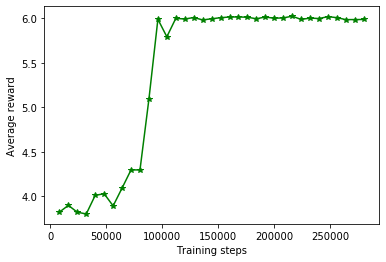

In [34]:
# Figure for overall reward for both cases: green(DQN_MLP), magenta: DQN_RC
plt.figure()
plt.plot(total_rec_num, o_mean_4,'g-*')
#plt.plot(total_rec_num, o_mean_1,'m-+')
#plt.plot(total_rec_num, o_mean_3, 'b-o')
#plt.ylim(3.5,6.15)
plt.ylabel('Average reward')
plt.xlabel('Training steps')
plt.show()

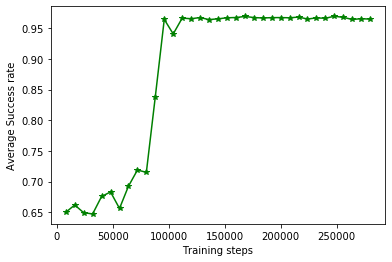

In [30]:
# Figure for success rate for both cases: green(DQN_MLP), magenta: DQN_RC
plt.figure()
plt.plot(total_rec_num, success_mean_4/batch_size,'g-*')
#plt.plot(total_rec_num, success_mean_1/batch_size,'m-+')
#plt.plot(total_rec_num, success_mean_3/batch_size,'b-^')

#plt.ylim(0.6,0.98)
plt.ylabel('Average Success rate')
plt.xlabel('Training steps')
plt.show()

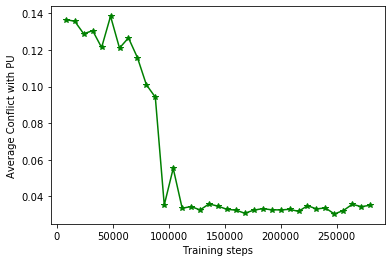

In [32]:
# Figure for collision with PU for both cases: green(DQN_MLP), magenta: DQN_RC
plt.figure()
plt.plot(total_rec_num, fail_PU_mean_4/batch_size,'g-*')
#plt.plot(total_rec_num, fail_PU_mean_1/batch_size,'m-+')
#plt.plot(total_rec_num, fail_PU_mean_3/batch_size,'b-^')
#plt.ylim(0, 0.175)
plt.ylabel('Average Conflict with PU')
plt.xlabel('Training steps')
plt.show()

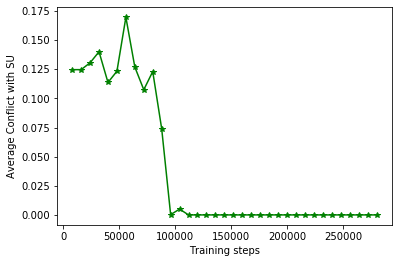

In [33]:
# Figure for collision with SU green(DQN_MLP), magenta: DQN_RC
plt.figure()
plt.plot(total_rec_num, fail_collision_mean_4/batch_size,'g-*')
#plt.plot(total_rec_num, fail_collision_mean_1/batch_size,'m-o')
#plt.plot(total_rec_num, fail_collision_mean_3/batch_size,'b-^')
#plt.ylim(0,0.2)
plt.ylabel('Average Conflict with SU')
plt.xlabel('Training steps')
plt.show()